### Network Monitoring Project

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import json 
import gc

df = pd.read_csv('/Users/jessting/Desktop/ISYE6333/Project/Detection_Matrix.csv', header=None)
display(df)
print(df.shape)
dtn = df.values

,0,1,2,3,4,5,6,7,8,9,...,801,802,803,804,805,806,807,808,809,810
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,...,0,1,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,0,0,0,0,1,...,0,1,1,0,0,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1120,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(1123, 811)


### <u>Parts A & B</u>:
Minimum number of sensors such that if any pipe bursts, at least one sensor will detect it:\
<u>Notation set-up</u>: 
- Let index $e$ denote pipes $e \in E=\{0,...,1122\}$, and index $v$ denotes sensors $v \in V=\{0,...,810\}$
- $f_{e,v} \in \{0, 1\}$ captures the sensing capabilities of sensor $v$ for pipe $e$
- Let $x_v = \{0, 1\}$ be a binary variable indicating whether a sensor is placed at location $v$
- Decision variables:
  $$\begin{align}
  x_v \forall  v \in \{0, ..., 810\}
  \end{align}$$
- Objective function:
  $$\begin{align}
  min \sum_{v \in V} x_v 
  \end{align}$$
- Constraints:
  $$\begin{align}
  \sum_{v\in{V}} f_{e,v} x_v \geq 1 \: \forall e\in{E}
  \end{align}$$

In [4]:
# Model set up
pipes, sensors = dtn.shape[0], dtn.shape[1]
nm_ab = gp.Model('Network Monitoring (a,b)')
x = nm_ab.addVars(sensors, vtype=GRB.BINARY, name='sensor')

# Objective function
nm_ab.setObjective(sum(x[v] for v in range(sensors)), GRB.MINIMIZE)

# Constraints
for e in range(pipes):
    nm_ab.addConstr(gp.quicksum(dtn[e, v] * x[v] for v in range(sensors)) >= 1, name=f'Pipe{e}_monitored')

# Solve
nm_ab.optimize()
if nm_ab.status == GRB.OPTIMAL:
    result = {
        'Optimal Sensors' : nm_ab.objVal,
        'Sensor Locations': [v for v in range(sensors) if x[v].x == 1]
    }
    print('Optimal solution found')
    print(result)
else:
    print('No optimal solution')
# {'Optimal Sensors': 19.0, 
# 'Sensor Locations': [16, 78, 87, 104, 156, 206, 277, 392, 394, 415, 424, 426, 429, 438, 482, 705, 712, 748, 798]}


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-04
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1123 rows, 811 columns and 132982 nonzeros
Model fingerprint: 0xd3f3f403
Variable types: 0 continuous, 811 integer (811 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 29.0000000
Presolve removed 1051 rows and 702 columns
Presolve time: 0.08s
Presolved: 72 rows, 109 columns, 2011 nonzeros
Found heuristic solution: objective 21.0000000
Variable types: 0 continuous, 109 integer (109 binary)

Root relaxation: objective 1.866667e+01, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds     

### <u>Parts C & D</u>:
Each pipe bursts with prob = 0.1, given $b$, the maximum number of sensors, locate sensors to maximize expected bursts detected:</br>
<u>Notation set-up</u>: 
- Let index $e$ denote pipes $e \in E=\{0,...,1122\}$, and index $v$ denotes sensors $v \in V=\{0,...,810\}$
- $f_{e,v} \in \{0, 1\}$ captures the sensing capabilities of sensor $v$ for pipe $e$
- $p_{e} = 0.1$ captures the probability that pipe $e$ bursts (set to 0.1 for all pipes)
- Let $x_v = \{0, 1\}$ be a binary variable indicating whether a sensor is placed at location $v$
- Let $y_e = \{0, 1\}$ be a binary variable indicating whether pipe $e$ is covered by at least one sensor
- Decision variables:
  $$\begin{align}
  x_v \forall  v \in \{0, ..., 810\} \\
  y_e \forall  e \in \{0, ..., 1122\}
  \end{align}$$
- Objective function:
  $$\begin{align}
  max \sum_{e \in E} p_e y_e 
  \end{align}$$
- Constraints:
  $$\begin{align}
  \sum_{v \in V} x_v & \leq b \\
  y_e \leq \sum_{v \in V} f_{e,v} x_v & \quad \forall e \in E \\
  y_e \geq \frac{1}{M} \sum_{v \in V} f_{e,v} x_v & \quad \forall e \in E
  \end{align}$$

In [2]:
# Load the existing results from JSON file (if it exists)
pipes, sensors = dtn.shape[0], dtn.shape[1]
prob = 0.1 # prob of burst pipe
avail_sensors = [b for b in range(21)] # possible number of sensors
filename = "cd_results.json"
try:
    with open(filename, "r") as file:
        results_dict = json.load(file)
        start_b = max(map(int, results_dict.keys())) + 1
        detection = [results_dict[str(b)]["Expected Bursts Detected"] for b in range(start_b)]
except (FileNotFoundError, ValueError):
    results_dict = {}
    start_b = 0
    detection = []

# Run the optimization loop from start_b
for b in avail_sensors[start_b:]:
    nm_cd = gp.Model("Network Monitoring (c,d)")
    nm_cd.setParam('Threads', 8)  

    # Define variables
    x = nm_cd.addVars(sensors, vtype=GRB.BINARY, name="sensor")
    y = nm_cd.addVars(pipes, vtype=GRB.BINARY, name="pipe")

    # Objective function
    nm_cd.setObjective(gp.quicksum(prob * y[e] for e in range(pipes)), GRB.MAXIMIZE)

    # Constraints
    nm_cd.addConstr(sum(x[v] for v in range(sensors)) <= b, name=f"Max_{b}_sensors")
    for e in range(pipes):
        nm_cd.addConstr(y[e] <= sum(dtn[e, v] * x[v] for v in range(sensors)), name=f"UB_pipe{e}")
        nm_cd.addConstr(y[e] >= (1 / sensors) * sum(dtn[e, v] * x[v] for v in range(sensors)), name=f"LB_pipe{e}")

    # Solve the model
    nm_cd.optimize()

    # Store results
    if nm_cd.status == GRB.OPTIMAL:
        obj_val = nm_cd.ObjVal
        detection.append(obj_val)
        results_dict[b] = {
            "Number of Sensors": b,
            "Expected Bursts Detected": obj_val,
            "Sensor Locations": [v for v in range(sensors) if x[v].x == 1]
        }
    else:
        detection.append(0)
        results_dict[b] = {
            "Number of Sensors": b,
            "Expected Bursts Detected": 0,
            "Sensor Locations": []
        }

    # Save results to JSON after each iteration
    with open(filename, "w") as file:
        json.dump(results_dict, file, indent=4)

    # Clean up the model to free memory and force garbage collection
    nm_cd.reset()
    del nm_cd, x, y
    gc.collect()

# Print the detection results
print(detection)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-04
Set parameter Threads to value 8
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 8 threads

Optimize a model with 2247 rows, 1934 columns and 269021 nonzeros
Model fingerprint: 0x17d520e2
Variable types: 0 continuous, 1934 integer (1934 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective -0.0000000
Sparsify removed 66457 nonzeros (81%)
Presolve removed 1209 rows and 134 columns
Presolve time: 0.50s
Presolved: 1038 rows, 1800 columns, 16023 nonzeros
Variable types: 8 continuous, 1792 integer (1442 binary)
Found heuristic solution: objective 3.0000000

Root relaxation: objective 1.071750e+02, 776 iterations, 0.02 seconds (

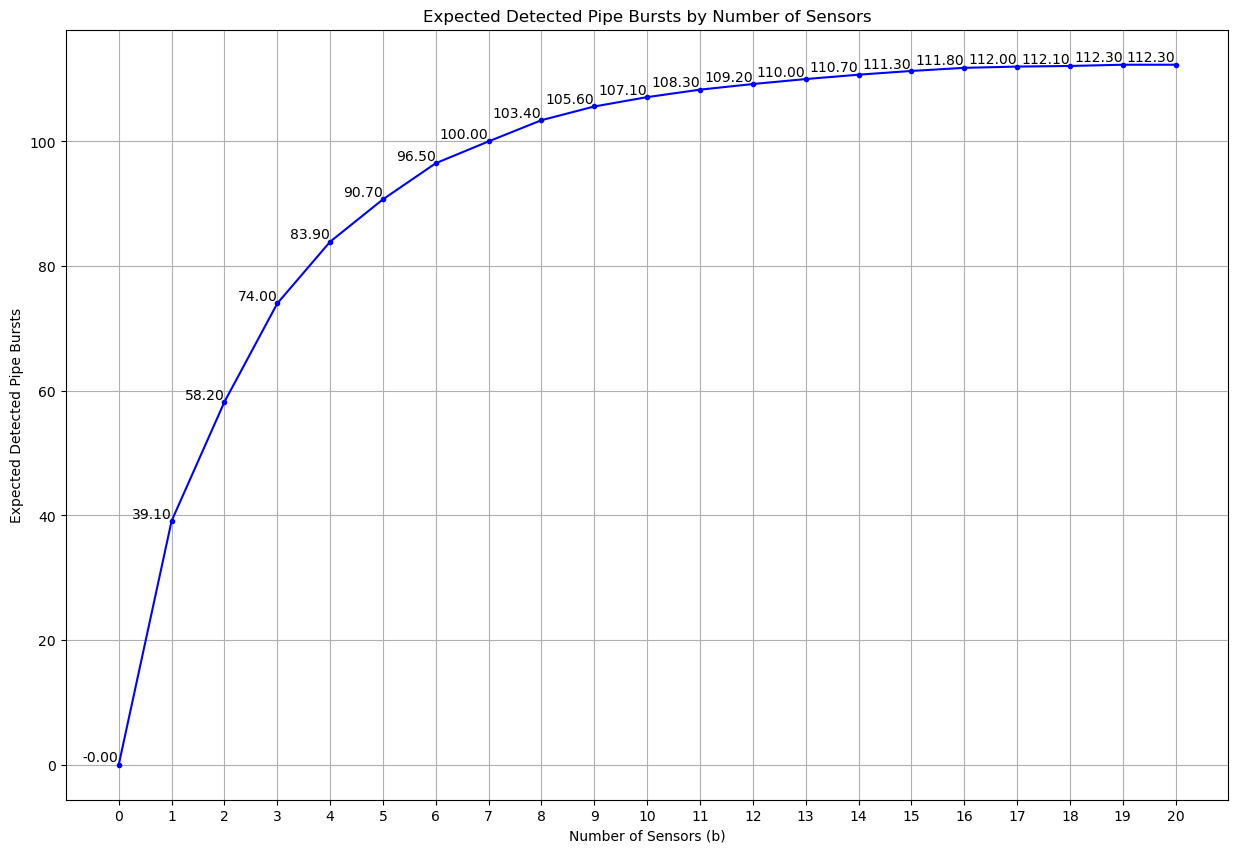

In [4]:
# Plot for expected bursts detected
plt.figure(figsize=(15,10))
plt.plot(avail_sensors, detection, color = 'blue', ls='-', marker='.')
plt.title('Expected Detected Pipe Bursts by Number of Sensors')
plt.xlabel('Number of Sensors (b)')
plt.xticks([i for i in range(21)])
plt.ylabel('Expected Detected Pipe Bursts')
plt.grid()
for b, detected in enumerate(detection):
    plt.text(b, detected, f'{detected:.2f}', ha = 'right', va = 'bottom', fontsize = 10, color='black')
plt.show()

### <u>Parts E</u>:
Iteratively place b sensors in location that detects maximum expected number of pipe bursts
- Place sensor at location $v$ with highest value of $\sum_{e \in{Enotdetected}} f_{e,v}$

In [5]:
### E ###
## Iteratively place b sensors in location that detects maximum expected number of pipe bursts
## Equivalent to placing sensor at v with highest value of $\sum_{e\inE&notdetected} f_{e,v}$
detection_iter = [0] # when b = 0 
chosen_sensors = [None] # when b = 0
detected_pipes = set()

for b in avail_sensors[1:]:
    chosen_sensor = None
    max_dtn = 0
    for v in range(sensors):
        exp_dtn = sum(prob * dtn[e, v] for e in range(pipes) if e not in detected_pipes) #prob*p(detection|burst) = prob*f_{e,v} for given sensor
        if exp_dtn > max_dtn: 
            chosen_sensor = v
            max_dtn = exp_dtn
    detection_iter.append(detection_iter[b-1] + max_dtn)
    chosen_sensors.append(chosen_sensor)
    detected_pipes.update([e for e in range(pipes) if dtn[e, chosen_sensor]==1])
print(detection_iter)

[0, 39.100000000000286, 56.20000000000026, 72.90000000000023, 80.50000000000023, 86.40000000000022, 91.80000000000021, 96.00000000000021, 99.40000000000022, 101.90000000000022, 103.80000000000022, 105.50000000000023, 106.80000000000022, 108.00000000000023, 108.80000000000022, 109.50000000000023, 110.10000000000022, 110.60000000000022, 111.00000000000023, 111.30000000000022, 111.60000000000022]


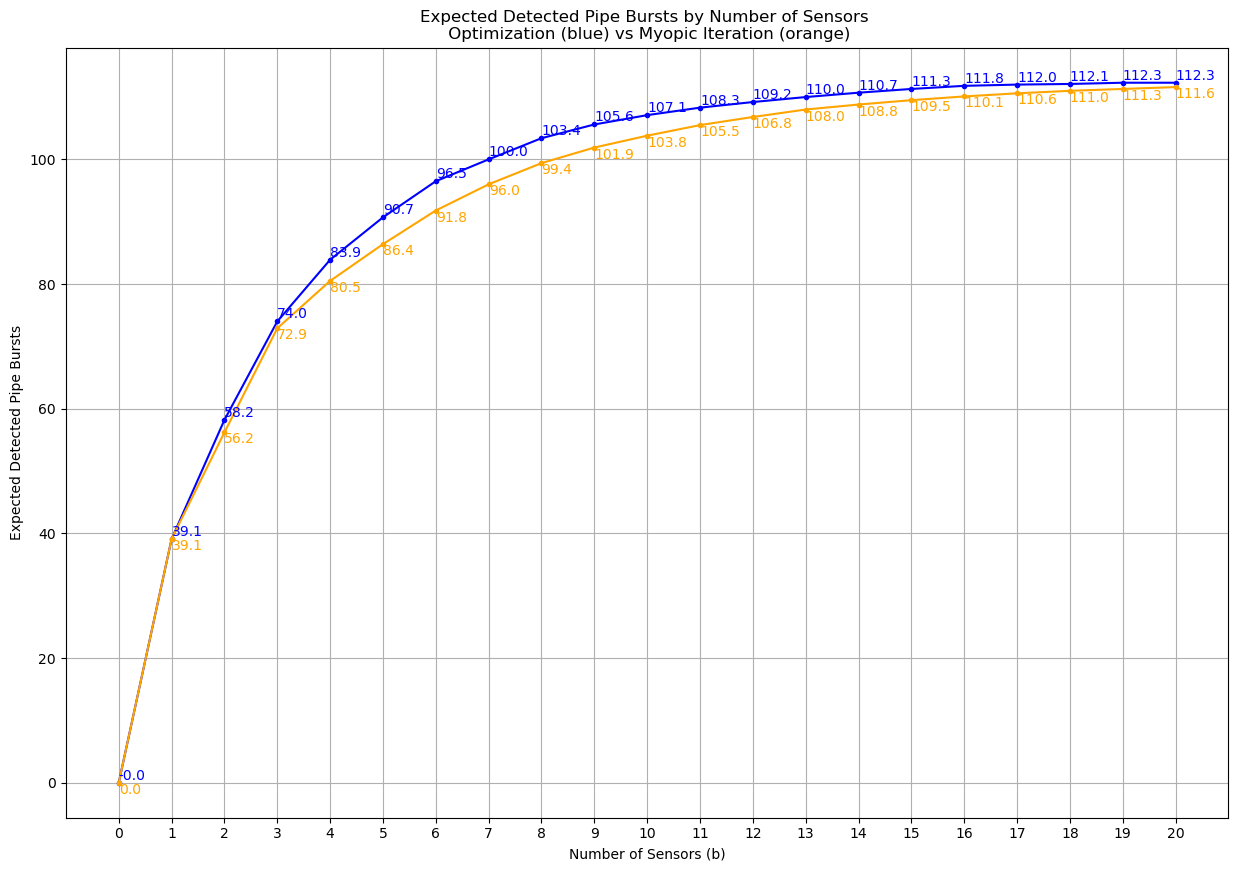

In [10]:
# Plot for expected bursts detected
plt.figure(figsize=(15,10))
plt.plot(avail_sensors, detection, color = 'blue', ls='-', marker='.', label = 'Optimized')
plt.plot(avail_sensors, detection_iter, color = 'orange', ls='-', marker='.', label = 'Myopic Iteration')
plt.title('Expected Detected Pipe Bursts by Number of Sensors \n Optimization (blue) vs Myopic Iteration (orange)')
plt.xlabel('Number of Sensors (b)')
plt.xticks([i for i in range(21)])
plt.ylabel('Expected Detected Pipe Bursts')
plt.grid()
for b, detected in enumerate(detection):
    plt.text(b, detected, f'{detected:.1f}', ha = 'left', va = 'bottom', fontsize = 10, color='blue')
for b, detected_iter in enumerate(detection_iter):
    plt.text(b, detected_iter, f'{detected_iter:.1f}', ha = 'left', va = 'top', fontsize = 10, color='orange')

plt.show()

### <u>Parts F & G</u>:
Each pipe bursts with prob = 0.1, and is associated with a criticality level $w_e \in [0, 1]$. Given $b$, the maximum number of sensors, locate sensors to minimize $max \{w_{e \in non-monitored}\}$: \
<u>Notation set-up</u>: 
- Let index $e$ denote pipes $e \in E=\{0,...,1122\}$, and index $v$ denotes sensors $v \in V=\{0,...,810\}$
- $f_{e,v} \in \{0, 1\}$ captures the sensing capabilities of sensor $v$ for pipe $e$
- $p_{e} = 0.1$ captures the probability that pipe $e$ bursts (set to 0.1 for all pipes)
- Let $x_v = \{0, 1\}$ be a binary variable indicating whether a sensor is placed at location $v$
- Let $y_e = \{0, 1\}$ be a binary variable indicating whether pipe $e$ is covered by at least one sensor
- Let $z = max \{w_{e \in non-monitored}\}$ be the maximum criticality among pipes that are not covered by at least one sensor
- Decision variables:
  $$\begin{align}
  x_v \forall  v \in \{0, ..., 810\} \\
  y_e \forall  e \in \{0, ..., 1122\}
  \end{align}$$
- Objective function:
  $$\begin{align}
  min \quad z
  \end{align}$$
- Constraints:
  $$\begin{align}
  \sum_{v \in V} x_v & \leq b \\
  y_e \leq \sum_{v \in V} f_{e,v} x_v & \quad \forall e \in E \\
  y_e \geq \frac{1}{M} \sum_{v \in V} f_{e,v} x_v & \quad \forall e \in E \\
  z \geq w_e \times (1-y_e) & \quad \forall e \in E
  \end{align}$$

In [2]:
pipes, sensors = dtn.shape[0], dtn.shape[1]
prob = 0.1 # prob of burst pipe
avail_sensors = [b for b in range(21)]
crit = pd.read_csv('/Users/jessting/Desktop/ISYE6333/Project/Criticality.csv', header = None)
crit.shape

detection_crit_dict = {}
results_file = 'fg_results.json'
try:
    with open(results_file, "r") as file:
        detection_crit_dict = json.load(file)
        start_b = max(map(int, detection_crit_dict.keys())) + 1
        detection_crit = [detection_crit_dict[str(b)]['Max Undetected Criticality'] for b in range(start_b)]
except (FileNotFoundError, ValueError):
    detection_crit_dict = {}
    start_b = 0
    detection_crit = []

for b in avail_sensors[start_b:]: 
    # Model
    nm_fg = gp.Model('Network Monitoring (f,g)')
    nm_fg.setParam('Threads', 4)
    x = nm_fg.addVars(sensors, vtype=GRB.BINARY, name='sensor')
    y = nm_fg.addVars(pipes, vtype=GRB.BINARY, name='pipes')
    z = nm_fg.addVar(vtype=GRB.CONTINUOUS, name='z')

    # Objective function
    nm_fg.setObjective(z, GRB.MINIMIZE)

    # Constraints
    nm_fg.addConstr(sum(x[v] for v in range(sensors)) <= b, name=f'Max_{b}_sensors')
    for e in range(pipes):
        nm_fg.addConstr(y[e] <= sum(dtn[e, v] * x[v] for v in range(sensors)), name=f'UB_pipe{e}')
        nm_fg.addConstr(y[e] >= (1/(sensors)) * sum(dtn[e, v] * x[v] for v in range(sensors)), name=f'LB_pipe{e}')
        nm_fg.addConstr(crit.iloc[e][0] * (1 - y[e]) <= z, name=f'Maxcrit_reform_pipe{e}')

    #Solve 
    nm_fg.optimize()
    if nm_fg.Status == GRB.OPTIMAL:
        detection_crit.append(nm_fg.ObjVal)
        detection_crit_dict[b] = {
            'Number of Sensors': b,
            'Max Undetected Criticality': nm_fg.objVal,
            'Sensor Locations': [v for v in range(sensors) if x[v].x == 1]
        }
    else:
        detection_crit.append(float('inf'))
        detection_crit_dict[b] = {
            'Number of Sensors': b,
            'Max Undetected Criticality': float('inf'), 
            'Sensor Locations': []
        }
    with open(results_file, 'w') as f:
        json.dump(detection_crit_dict, f, indent=4)
    nm_fg.reset() 
    del nm_fg, x, y 
    gc.collect()

print(detection_crit)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-04
Set parameter Threads to value 4
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 4 threads

Optimize a model with 3370 rows, 1935 columns and 271267 nonzeros
Model fingerprint: 0x03e06360
Variable types: 1 continuous, 1934 integer (1934 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 2e+01]
Found heuristic solution: objective 1.0000000
Presolve added 11 rows and 0 columns
Presolve removed 0 rows and 26 columns
Presolve time: 0.19s
Presolved: 3381 rows, 1909 columns, 243007 nonzeros
Variable types: 0 continuous, 1909 integer (1883 binary)

Root relaxation: objective 8.560170e-02, 1634 iterations, 0.05 seconds (0.15 work units)

    Nodes    |    Current Node  

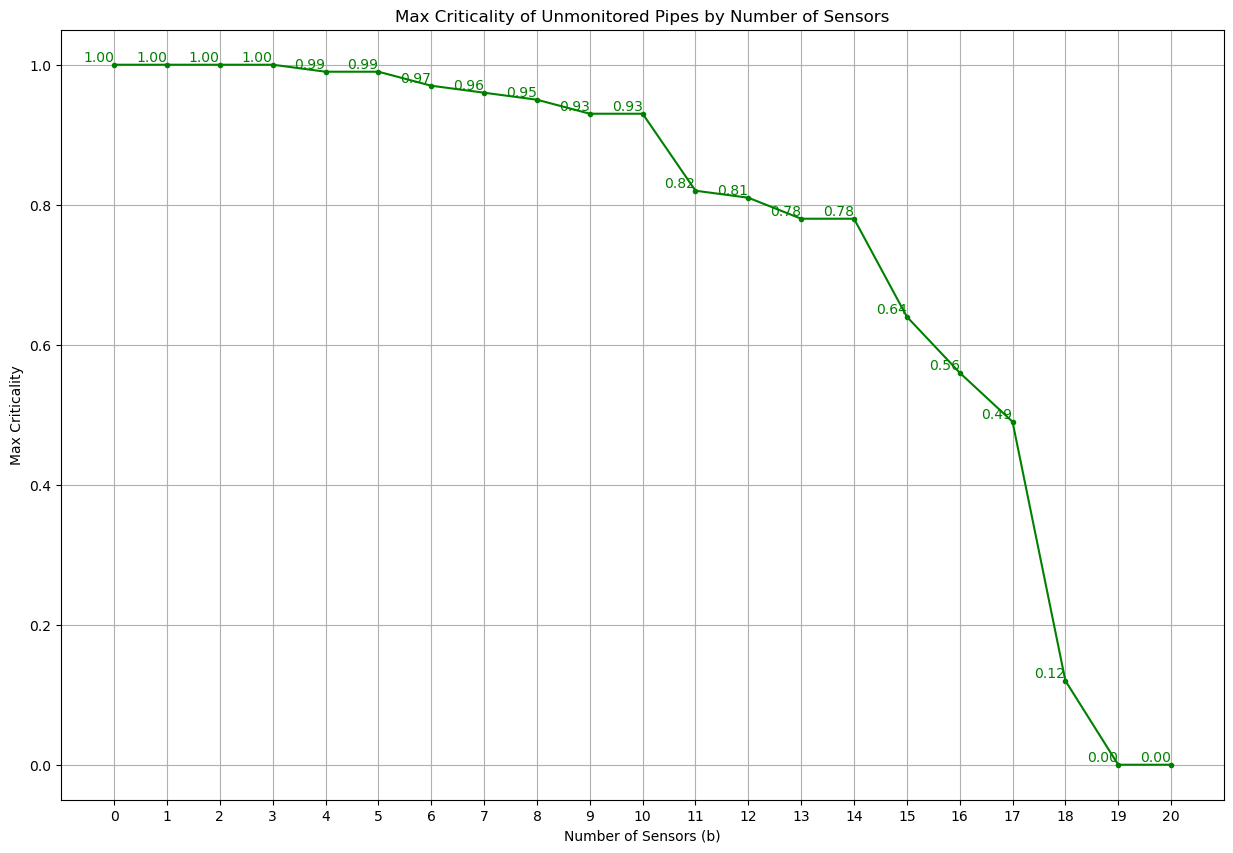

In [3]:
# Plot for max criticality of unmonitored pipes
plt.figure(figsize=(15,10))
plt.plot(avail_sensors, detection_crit, color = 'green', ls='-', marker='.')
plt.title('Max Criticality of Unmonitored Pipes by Number of Sensors')
plt.xlabel('Number of Sensors (b)')
plt.xticks([i for i in range(21)])
plt.ylabel('Max Criticality')
plt.grid()
for b, detected_crit in enumerate(detection_crit):
    plt.text(b, detected_crit, f'{detected_crit:.2f}', ha = 'right', va = 'bottom', fontsize = 10, color='green')

plt.show()